In [1]:

import os
import torch
import numpy as np
import scipy.stats
from collections import defaultdict
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.util import ignore_jit_warnings

pyro.clear_param_store()
pyro.set_rng_seed(1)


In [2]:

import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import skew
from scipy.spatial.distance import cityblock

rtdata = pd.read_csv('mcfrt.csv')
rtdata = rtdata.query('chr == "1"')
rtdata


,chr,start,end,gc,mcf7rt,bin_size
0,1,1000000,1500000,0.598330,81.441980,500000
1,1,1500000,2000000,0.539496,79.131013,500000
2,1,2000000,2500000,0.594508,78.557313,500000
3,1,3000000,3500000,0.584570,70.388076,500000
4,1,4000000,4500000,0.482572,48.663092,500000
...,...,...,...,...,...,...
423,1,246000000,246500000,0.404142,47.146415,500000
424,1,246500000,247000000,0.428546,70.978030,500000
425,1,247000000,247500000,0.425162,58.722962,500000
426,1,247500000,248000000,0.400436,30.497224,500000


In [3]:

import matplotlib.pyplot as plt
import seaborn as sns

rtdata['norm_mcf7rt'] = (rtdata['mcf7rt'] - rtdata['mcf7rt'].min()) / (rtdata['mcf7rt'].max() - rtdata['mcf7rt'].min())

sns.lineplot(x='start', y='norm_mcf7rt', data=rtdata)


<AxesSubplot:xlabel='start', ylabel='norm_mcf7rt'>

In [4]:

starts = rtdata['start'].values
rt = rtdata['norm_mcf7rt'].values
gc = rtdata['gc'].values
num_cells = 170
num_loci = 400

cn = np.ones((rt.shape[0], num_cells)) * 2

starts = starts[:num_loci]
rt = torch.tensor(rt[:num_loci])
gc = torch.tensor(gc[:num_loci])
cn = torch.tensor(cn[:num_loci, :])

# add a CNA for 30 cells in the first 30 bins
cn[:30, :30] = 1

# assign cells to 2 different libraries
libs = torch.randint(2, (num_cells,)).to(torch.int64)

In [5]:
libs.dtype

torch.int64

### Play around with using true `cn` to create a reasonable prior for `cn_prob`

In [6]:
def make_cn_prior(cn, weight=10, num_states=13):
    num_loci, num_cells = cn.shape
    cn_prior = torch.ones(num_loci, num_cells, num_states)
    for i in range(num_loci):
        for n in range(num_cells):
            state = int(cn[i, n].numpy())
            cn_prior[i, n, state] = weight
    return cn_prior

def make_diploid_prior(cn, weight=10, num_states=13):
    num_loci, num_cells = cn.shape
    cn_prior = torch.ones(num_loci, num_cells, num_states)
    cn_prior[:, :, 2] = weight
    return cn_prior

### Define generative model for G1-phase cells

In [7]:
def make_gc_features(x, poly_degree=4):
    """Builds features i.e. a matrix with columns [x, x^2, x^3, x^4]."""
    x = x.unsqueeze(1)
    return torch.cat([x ** i for i in reversed(range(0, poly_degree+1))], 1)

softplus = torch.nn.Softplus()
relu = torch.nn.ReLU()

@config_enumerate
def model_g1(gc_profile, libs, cn=None, num_cells=None, num_loci=None, data=None, poly_degree=4):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn is not None:
            num_loci, num_cells = cn.shape
        assert num_cells is not None
        assert num_loci is not None
        num_libraries = int(torch.max(libs).item() + 1)

    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

    # gc bias params
    beta_means = pyro.sample('expose_beta_means', dist.Normal(0., 1.).expand([num_libraries, poly_degree+1]).to_event(2))
    beta_stds = pyro.param('expose_beta_stds', torch.logspace(start=0, end=-poly_degree, steps=(poly_degree+1)).reshape(1, -1).expand([num_libraries, poly_degree+1]),
                           constraint=constraints.positive)

    with pyro.plate('num_cells', num_cells):

        # per cell reads per copy per bin
        # u should be inversely related to cn, positively related to reads
        if (data is not None) and (cn is not None):
            cell_ploidies = torch.mean(cn.type(torch.float32), dim=0)
            u_guess = torch.mean(data.type(torch.float32), dim=0) / cell_ploidies
        else:
            u_guess = torch.tensor([70.])
        
        u_stdev = u_guess / 10.

        u = pyro.sample('expose_u', dist.Normal(u_guess, u_stdev))
        
        # sample beta params for each cell based on which library the cell belongs to
        betas = pyro.sample('expose_betas', dist.Normal(beta_means[libs], beta_stds[libs]).to_event(1))
        
        with pyro.plate('num_loci', num_loci):

            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile, poly_degree=poly_degree).reshape(num_loci, 1, poly_degree+1)
            gc_rate = torch.exp(torch.sum(torch.mul(betas, gc_features), 2))
            biased_cn = cn * gc_rate

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)

            if data is not None:
                obs = data
            else:
                obs = None

            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

### Simulate data for G1-phase cells

In [8]:
# beta_means_g1 = torch.tensor([[0.1, 0.2, -1, 1, -0.25], [0.15, 0.1, -1, 1, -0.25]])*10.
beta_means_g1 = torch.tensor([[0.1, 0.2, -1, 1, -0.25], [0.15, 0.1, -2, 1.5, -0.25]])*10.
beta_stds_g1 = torch.logspace(start=0, end=-4, steps=5).reshape(1, -1).expand([2, -1])
beta_means_g1, beta_stds_g1

(tensor([[  1.0000,   2.0000, -10.0000,  10.0000,  -2.5000],
         [  1.5000,   1.0000, -20.0000,  15.0000,  -2.5000]]),
 tensor([[1.0000e+00, 1.0000e-01, 1.0000e-02, 1.0000e-03, 1.0000e-04],
         [1.0000e+00, 1.0000e-01, 1.0000e-02, 1.0000e-03, 1.0000e-04]]))

In [9]:
pyro.clear_param_store()

conditioned_model_g1 = poutine.condition(
    model_g1,
    data={
        'expose_beta_means': beta_means_g1,
        'expose_beta_stds': beta_stds_g1
    })

def simulate_g1_data(model, gc, libs, cn):
    pyro.clear_param_store()
    model_trace_g1 = pyro.poutine.trace(model)
    samples_g1 = model_trace_g1.get_trace(gc, libs, cn)

    betas_g1 = samples_g1.nodes['expose_betas']['value']
    u_g1 = samples_g1.nodes['expose_u']['value']
    nb_r_g1 = samples_g1.nodes['expose_nb_r']['value']
    reads_g1 = samples_g1.nodes['reads']['value']
    
    reads_per_cell = torch.mean(reads_g1) * cn.shape[0]
    reads_norm_g1 = (reads_g1 / torch.sum(reads_g1, 0)) * reads_per_cell
    
    reads_g1 = reads_g1.type(torch.float32)
    reads_norm_g1 = reads_norm_g1.type(torch.int64)
    reads_norm_g1 = reads_norm_g1.type(torch.float32)

    return betas_g1, u_g1, nb_r_g1, reads_g1, reads_norm_g1


In [10]:
betas_g1, u_g1, nb_r_g1, reads_g1, reads_norm_g1 = simulate_g1_data(conditioned_model_g1, gc, libs, cn)

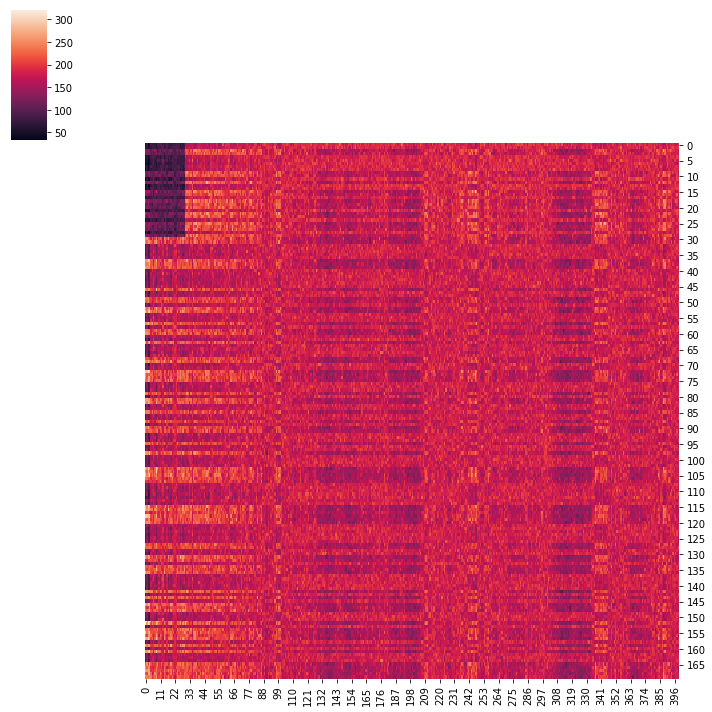

In [11]:
sns.clustermap(reads_norm_g1.numpy().astype(float).T, col_cluster=False, row_cluster=False)
plt.show()

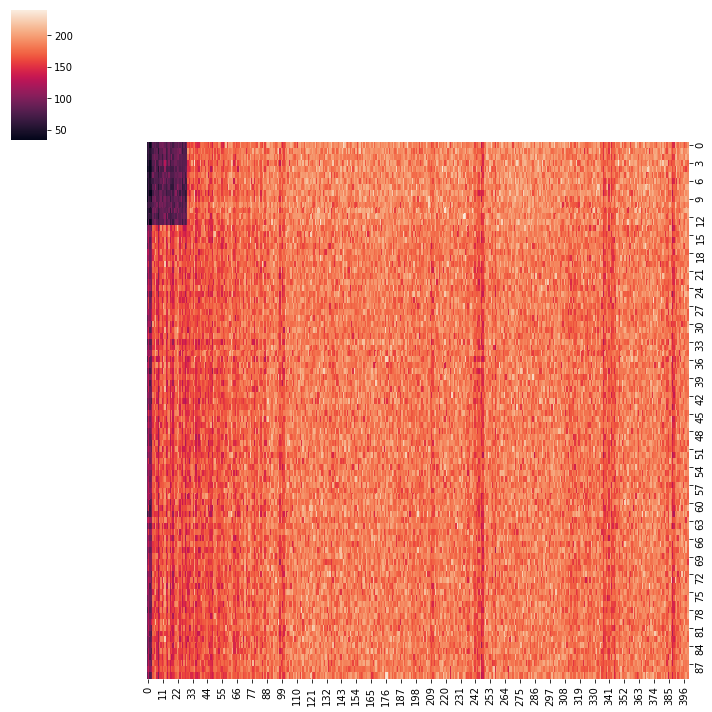

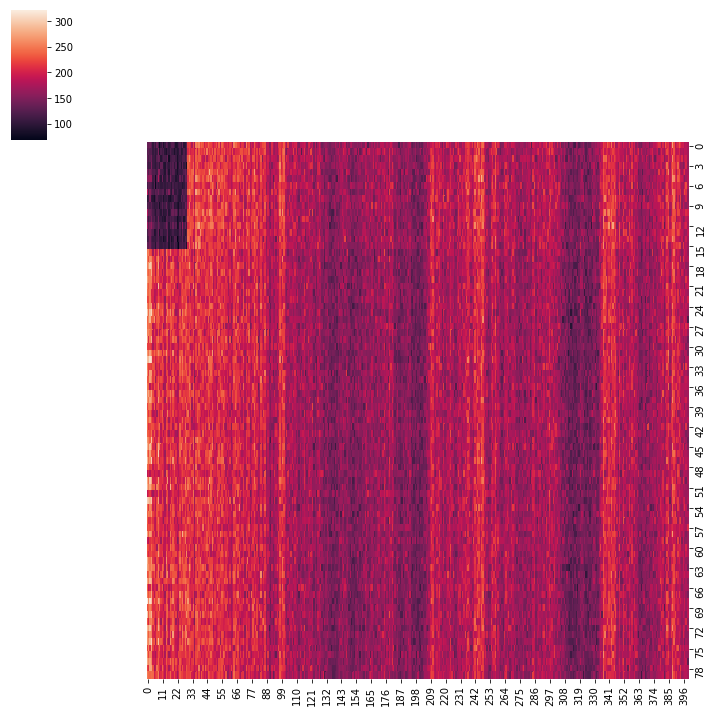

In [12]:
# plot reads heatmap separately for each library
sns.clustermap(reads_norm_g1[:, (libs==1).nonzero().flatten()].numpy().astype(float).T, col_cluster=False, row_cluster=False)
plt.show()

sns.clustermap(reads_norm_g1[:, (libs==0).nonzero().flatten()].numpy().astype(float).T, col_cluster=False, row_cluster=False)
plt.show()

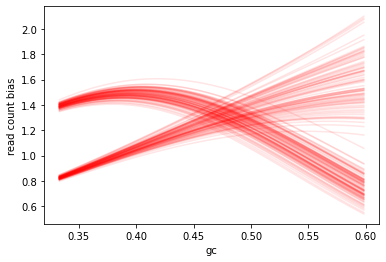

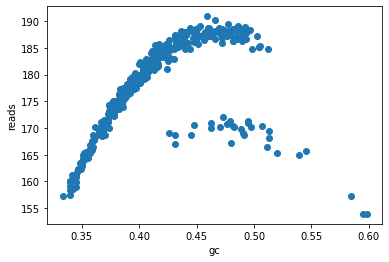

In [13]:
# plot gc bias curve
x = np.linspace(min(gc), max(gc), 101)  # gc values

for i in range(num_cells):
    p1d = np.poly1d(betas_g1[i].detach().numpy())
    mean = np.exp(p1d(x))
    plt.plot(x, mean, c='r', alpha=0.1)

plt.xlabel('gc')
plt.ylabel('read count bias')
plt.show()

plt.scatter(x=gc, y=torch.mean(reads_norm_g1, dim=1))
plt.xlabel('gc')
plt.ylabel('reads')
plt.show()

### Infer betas using G1-phase model

In [14]:
cn = cn.type(torch.float32)
reads_g1 = reads_g1.type(torch.float32)
reads_norm_g1 = reads_norm_g1.type(torch.float32)
gc = gc.type(torch.float32)

In [15]:
conditioned_model_g1 = poutine.condition(
    model_g1,
    data={
#         'expose_betas': torch.tensor([0.1, 0.2, -1, 1, -0.25])*10.,
#         'expose_nb_r': 10000.0,
#         'expose_u': all_u_g1[23]
    })

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2)

guide_g1 = AutoDelta(
    poutine.block(conditioned_model_g1, expose_fn=lambda msg: msg["name"].startswith("expose_"))
)

svi = SVI(conditioned_model_g1, guide_g1, optim, loss=elbo)


In [16]:
elbo.loss(conditioned_model_g1, guide_g1, gc, libs, cn=cn, data=reads_norm_g1)

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py:356: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  "TraceEnum_ELBO found no sample sites configured for enumeration. "


665766.0625

In [17]:
# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi.step(gc, libs, cn=cn, data=reads_norm_g1)
    
    if i >= 100:
        loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
        if loss_diff < 5e-5:
            print('ELBO converged at iteration ' + str(i))
            break
    
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')



...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

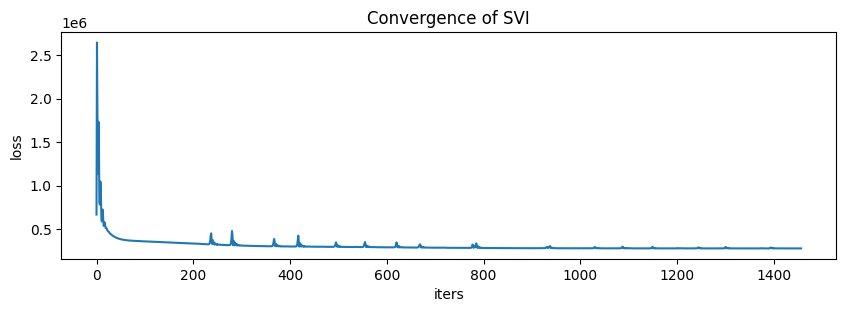

In [18]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');

In [19]:
# replay model
guide_trace_g1 = poutine.trace(guide_g1).get_trace(gc, libs, cn=cn, data=reads_norm_g1)
trained_model_g1 = poutine.replay(model_g1, trace=guide_trace_g1)

# infer discrete sites and get model trace
inferred_model_g1 = infer_discrete(
    trained_model_g1, temperature=0,
    first_available_dim=-3)
trace_g1 = poutine.trace(inferred_model_g1).get_trace(gc, libs, cn=cn, data=reads_norm_g1)

# extract fitted parameters
nb_r_fit = trace_g1.nodes['expose_nb_r']['value']
betas_fit = trace_g1.nodes['expose_betas']['value']
beta_means_fit = trace_g1.nodes['expose_beta_means']['value']
beta_stds_fit = trace_g1.nodes['expose_beta_stds']['value']
u_fit = trace_g1.nodes['expose_u']['value']

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/discrete.py:99: UserWarning: infer_discrete found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}.
  "infer_discrete found no sample sites configured for enumeration. "


In [20]:
betas_g1.shape, betas_fit.shape

(torch.Size([170, 5]), torch.Size([170, 5]))

In [21]:
beta_means_fit.shape, beta_stds_fit.shape

(torch.Size([2, 5]), torch.Size([2, 5]))

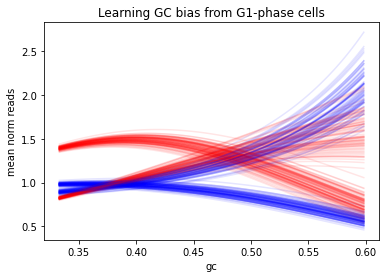

In [22]:
x = np.linspace(min(gc), max(gc), 101)  # gc values

# plt.scatter(x=gc, y=torch.mean(reads_g1, dim=1))

# true gc betas
for i in range(num_cells):
    p1d = np.poly1d(betas_g1[i].detach().numpy())
    mean = np.exp(p1d(x))
    plt.plot(x, mean, 'r', alpha=0.1)

    # inferred gc betas
    p1d_fit = np.poly1d(betas_fit[i].detach().numpy())
    mean_fit = np.exp(p1d_fit(x))
    plt.plot(x, mean_fit, 'b', alpha=0.1)

plt.xlabel('gc')
plt.ylabel('mean norm reads')
plt.title('Learning GC bias from G1-phase cells')
#plt.legend()
plt.show()

### Define generative model

In [23]:

@config_enumerate
def model_S(gc_profile, libs, cn0=None, rt0=None, num_cells=None, num_loci=None, poly_degree=4, data=None, cn_prior=None, t_alpha_prior=None, t_beta_prior=None, t_init=None):
    assert (num_cells is None) != (data is None)

    if data is not None:
        num_loci, num_cells = data.shape
    elif cn0 is not None:
        num_loci, num_cells = cn0.shape
    num_libraries = int(torch.max(libs).item() + 1)

    # controls the consistency of replicating on time
    a = pyro.param('a', torch.tensor([10.]))
    
    # negative binomial dispersion
    nb_r = pyro.param('nb_r', torch.tensor([10000.0]), constraint=constraints.positive)
    
    # gc bias params
    # these should be conditioned based on fitted values for G1-phase cells
    beta_means = pyro.sample('beta_means', dist.Normal(0., 1.).expand([num_libraries, poly_degree+1]).to_event(2))
    beta_stds = pyro.param('beta_stds', torch.logspace(start=0, end=-poly_degree, steps=(poly_degree+1)).reshape(1, -1).expand([num_libraries, poly_degree+1]),
                           constraint=constraints.positive)
    
    if rt0 is not None:
        # fix rt as constant when input into model
        rt = rt0
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('rt', dist.Normal(torch.ones(num_loci)*0.5, 0.1))
    
    # fix cn as constant when input into model
    if cn0 is not None:
        cn = cn0

    with pyro.plate('num_cells', num_cells):
        
        # per cell replication time
        # draw from prior if provided
        if (t_alpha_prior is not None) and (t_beta_prior is not None):
            t = pyro.sample('t', dist.Beta(t_alpha_prior, t_beta_prior))
        elif t_init is not None:
            t = pyro.param('t', t_init, constraint=constraints.unit_interval)
        else:
            t = pyro.sample('t', dist.Beta(torch.tensor([1.5]), torch.tensor([1.5])))
        
        # per cell reads per copy per bin
        # u should be inversely related to t and cn, positively related to reads
        if data is not None:
            if cn0 is not None:
                cell_ploidies = torch.mean(cn0.type(torch.float32), dim=0)
            elif cn_prior is not None:
                temp_cn0 = torch.argmax(cn_prior, dim=2).type(torch.float32)
                cell_ploidies = torch.mean(temp_cn0, dim=0)
            else:
                cell_ploidies = torch.ones(num_cells) * 2.
            u_guess = torch.mean(data.type(torch.float32), dim=0) / ((1 + t) * cell_ploidies)
            # u_guess = torch.mean(data.type(torch.float32), dim=0) / cell_ploidies
        else:
            u_guess = torch.tensor([70.])
        
        u_stdev = u_guess / 10.
    
        u = pyro.sample('u', dist.Normal(u_guess, u_stdev))
        
        # sample beta params for each cell based on which library the cell belongs to
        betas = pyro.sample('betas', dist.Normal(beta_means[libs], beta_stds[libs]).to_event(1))

        with pyro.plate('num_loci', num_loci):
            
            if cn0 is None:
                if cn_prior is None:
                    cn_prior = torch.ones(num_loci, num_cells, 13)
                # sample cn probabilities of each bin from Dirichlet
                cn_prob = pyro.sample('cn_prob', dist.Dirichlet(cn_prior))
                # sample cn state from categorical based on cn_prob
                cn = pyro.sample('cn', dist.Categorical(cn_prob))

            # per cell per bin late or early 
            t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * t_diff))
            
            # binary replicated indicator
            rep = pyro.sample('rep', dist.Bernoulli(p_rep))

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)
            
            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile, poly_degree=poly_degree).reshape(num_loci, 1, poly_degree+1)
            gc_rate = torch.exp(torch.sum(torch.mul(betas, gc_features), 2))
            biased_cn = rep_cn * gc_rate

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=data)

# trace = poutine.trace(model_S).get_trace(cn, rt, num_cells=num_cells)
# trace.compute_log_prob()
# print(trace.format_shapes())
# pyro.render_model(model_S, model_args=(cn, rt, num_cells), 
#                   render_distributions=True, render_params=True)

  Trace Shapes:               
   Param Sites:               
              a         1     
           nb_r         1     
      beta_stds       2 5     
  Sample Sites:               
beta_means dist         |  2 5
          value         |  2 5
       log_prob         |     
 num_loci0 dist         |     
          value     400 |     
       log_prob         |     
        rt dist     400 |     
          value     400 |     
       log_prob     400 |     
 num_cells dist         |     
          value     170 |     
       log_prob         |     
         t dist     170 |     
          value     170 |     
       log_prob     170 |     
         u dist     170 |     
          value     170 |     
       log_prob     170 |     
     betas dist     170 |  5  
          value     170 |  5  
       log_prob     170 |     
  num_loci dist         |     
          value     400 |     
       log_prob         |     
   cn_prob dist 400 170 | 13  
          value 400 170 | 13  
       l

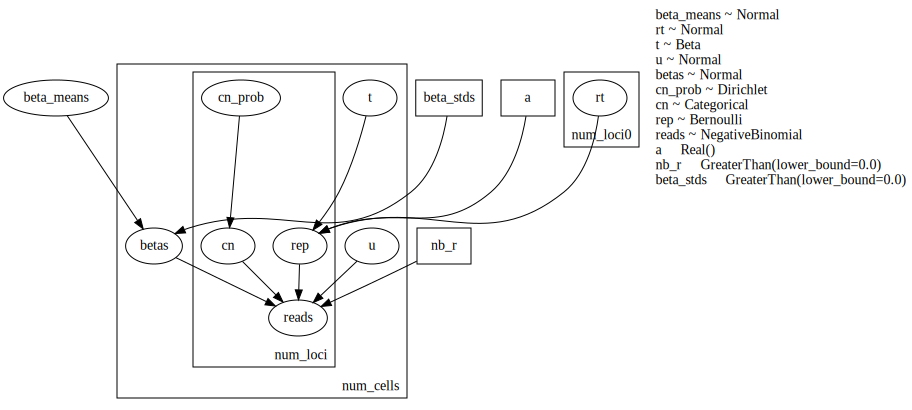

In [24]:
trace = poutine.trace(model_S).get_trace(gc, libs, None, num_cells=num_cells, num_loci=num_loci)
trace.compute_log_prob()
print(trace.format_shapes())
pyro.render_model(model_S, model_args=(gc, libs, None, None, num_cells, num_loci), 
                  render_distributions=True, render_params=True)

### Simulate and visualize data

In [25]:
# Simulate conditioned on a and betas, get reads, replication timing etc

def simulate_s_cells(model, gc, libs, cn, rt, num_cells, condition_dict={}):
    pyro.clear_param_store()
    
    conditioned_model = poutine.condition(model, data=condition_dict)

    model_trace = pyro.poutine.trace(conditioned_model)

    samples = model_trace.get_trace(gc, libs, cn, rt, num_cells=num_cells)
    
    t = samples.nodes['t']['value']
    a = samples.nodes['a']['value']
    u = samples.nodes['u']['value']
    nb_r = samples.nodes['nb_r']['value']
    betas = samples.nodes['betas']['value']

    t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)
    p_rep = 1 / (1 + torch.exp(-a * t_diff))

    rep = samples.nodes['rep']['value']

    rep_cn = cn * (1. + rep)

    reads = samples.nodes['reads']['value']
    
    return reads, rep_cn, rep, p_rep, betas, nb_r, u, a, t


In [26]:
# simulate cells from all cycle states from the S-phase model
# note that I am no longer using this function -- I'm just simulating S-phase cells here

def simulate_all_phases(model, gc, libs, cn, rt, condition_dict={}):
    num_loci, num_cells = cn.shape
    
    # simulate s-phase cells
    condition_dict_s = condition_dict.copy()
    reads_s, rep_cn_s, rep_s, p_rep_s, betas_s, nb_r_s, u_s, a_s, t_s = simulate_s_cells(
        model, gc, libs, cn, rt, num_cells, condition_dict=condition_dict_s
    )
    
    # simulate G1-phase cells
    condition_dict_g1 = condition_dict.copy()
    condition_dict_g1['t'] = torch.zeros(num_cells)
    # condition_dict_g1['rep'] = torch.zeros(num_loci, num_cells)
    reads_g1, rep_cn_g1, rep_g1, p_rep_g1, betas_g1, nb_r_g1, u_g1, a_g1, t_g1 = simulate_s_cells(
        model, gc, libs, cn, rt, num_cells, condition_dict=condition_dict_g1
    )
    
    # simulate G2-phase cells
    condition_dict_g2 = condition_dict.copy()
    condition_dict_g2['t'] = torch.ones(num_cells)
    # condition_dict_g2['rep'] = torch.ones(num_loci, num_cells)
    reads_g2, rep_cn_g2, rep_g2, p_rep_g2, betas_g2, nb_r_g2, u_g2, a_g2, t_g2 = simulate_s_cells(
        model, gc, libs, cn, rt, num_cells, condition_dict=condition_dict_g2
    )
    
    # concatenate along cell axis for cell params
    reads = torch.cat([reads_s, reads_g1, reads_g2], 1)
    rep_cn = torch.cat([rep_cn_s, rep_cn_g1, rep_cn_g2], 1)
    rep = torch.cat([rep_s, rep_g1, rep_g2], 1)
    p_rep = torch.cat([p_rep_s, p_rep_g1, p_rep_g2], 1)
    betas = torch.cat([betas_s, betas_g1, betas_g2], 0)
    t = torch.cat([t_s, t_g1, t_g2], 0)
    u = torch.cat([u_s, u_g1, u_g2], 0)
    
    # no need to concat global params such as a or nb_r
    a = a_s
    nb_r = nb_r_s
    
    # need to return cn and num_cells that match simulated reads
    cn_out = torch.cat([cn, cn, cn], 1)
    num_cells_out = cn_out.shape[1]
    
    return reads, rep_cn, rep, p_rep, betas, nb_r, u, a, t, cn_out, num_cells_out

condition_dict = {
    'nb_r': torch.tensor([10000.0]),
    'a': torch.tensor([10.]),
    'beta_means': beta_means_g1,
    'beta_stds': beta_stds_g1
}

# reads, rep_cn, rep, p_rep, betas_s, nb_r, u, a, t, cn, num_cells = simulate_all_phases(
#     model_S, gc, libs, cn, rt, condition_dict=condition_dict
# )

reads, rep_cn, rep, p_rep, betas_s, nb_r, u, a, t = simulate_s_cells(
    model_S, gc, libs, cn, rt, num_cells, condition_dict=condition_dict
)

In [27]:
# come up with initialization for phase probabilities
# cheating to start: going to say that G1 and G2 phase cells start at 0.1 and S-phase cells start at 0.9
# p_phase_init = torch.ones(num_cells) * 0.1
# p_phase_init[:int(num_cells/3)] = 0.9

In [28]:
# make cn priors based on new cn
cn_prior = make_cn_prior(cn)
diploid_cn_prior = make_diploid_prior(cn)

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


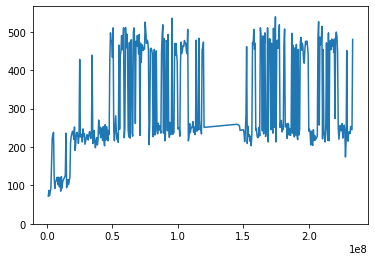

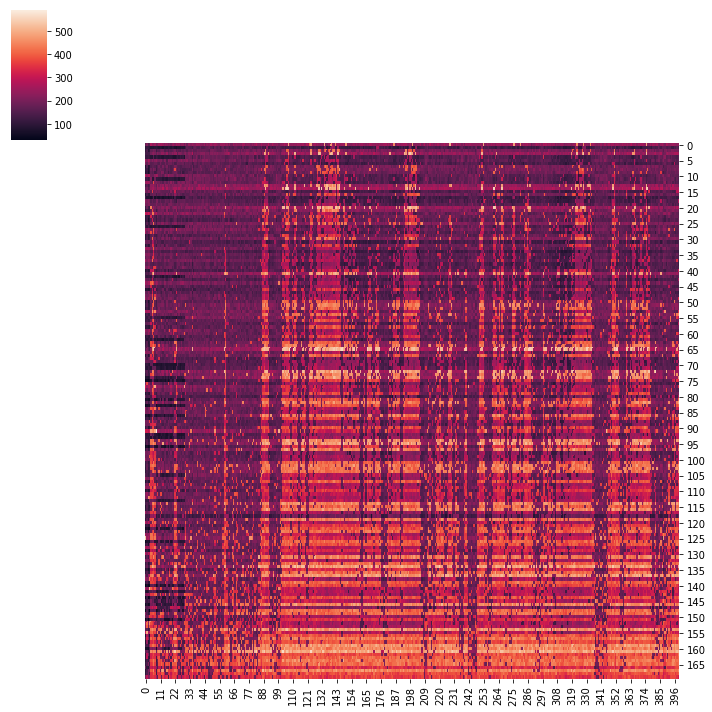

In [29]:
# Visualize one cell and matrix

sns.lineplot(starts, reads[:, 1])
plt.ylim((0, 1.05 * reads[:, 1].max()))

sns.clustermap(reads.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)

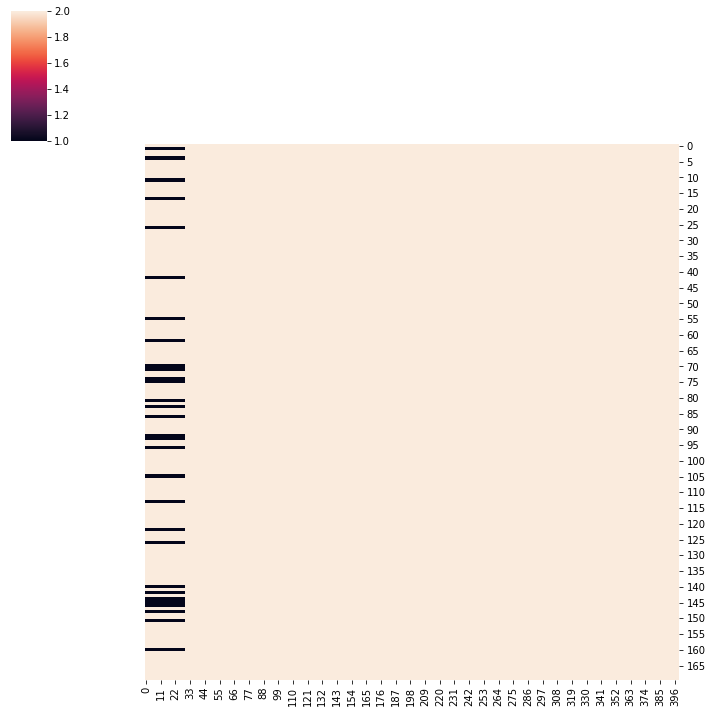

In [30]:
# visualize the true copy number heatmap
sns.clustermap(cn.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)
plt.show()

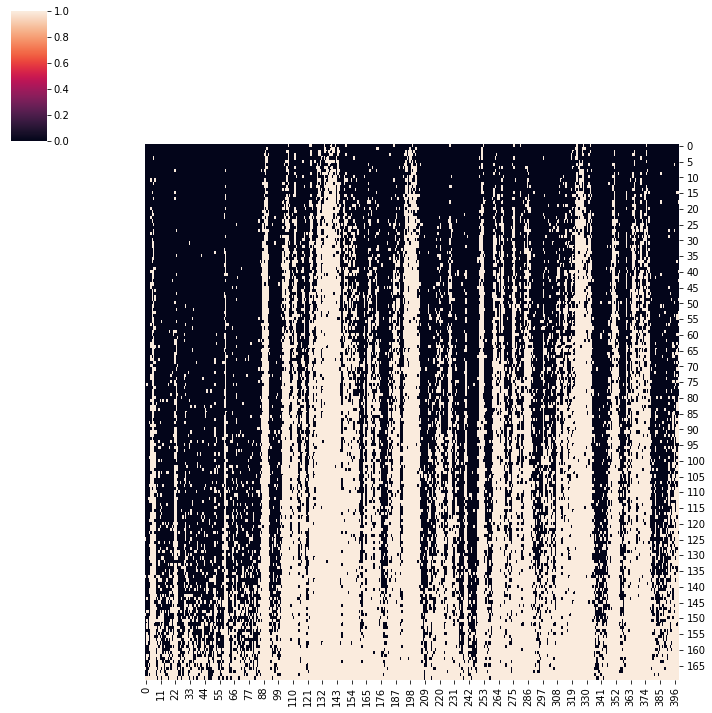

In [31]:
# visualize the true replication heatmap
sns.clustermap(rep.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)
plt.show()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


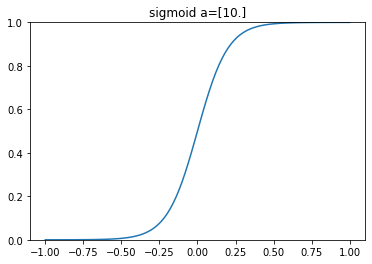

In [32]:
def plot_sigmoid(a):
    x = np.linspace(-1, 1, 101)
    y = 1 / (1 + np.exp(-a * x))

    sns.lineplot(x, y)
    plt.title(f'sigmoid a={a}')
    plt.ylim((0, 1))

plot_sigmoid(a.detach().numpy())


### Normalize each cell to the same total number of reads

In [33]:
reads_per_cell = torch.mean(reads) * num_loci
reads_norm = (reads / torch.sum(reads, 0)) * reads_per_cell
reads_norm = reads_norm.type(torch.int64)

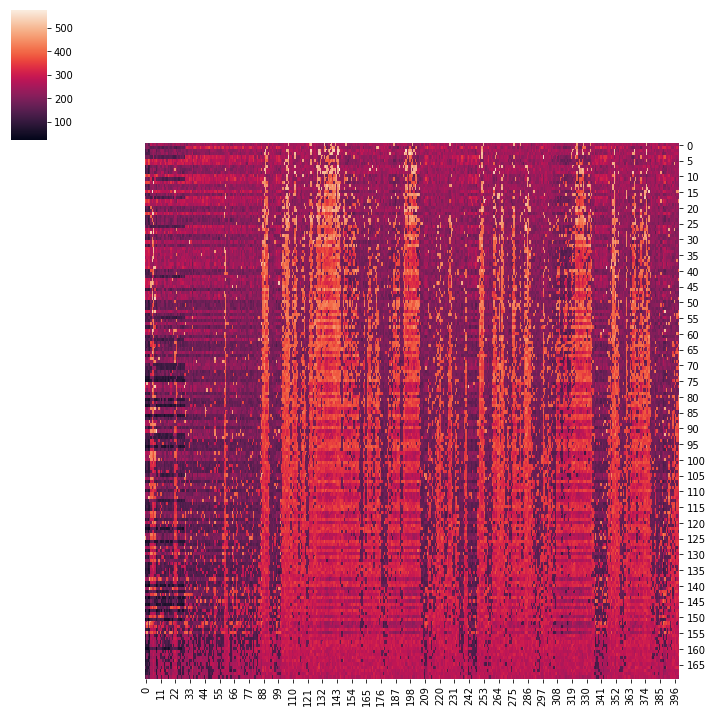

In [34]:
sns.clustermap(reads_norm.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)
plt.show()

In [35]:
cn = cn.type(torch.float32)
reads = reads.type(torch.float32)
reads_norm = reads_norm.type(torch.float32)
cn_prior = cn_prior.type(torch.float32)
diploid_cn_prior = diploid_cn_prior.type(torch.float32)
rt = rt.type(torch.float32)
t = t.type(torch.float32)

### Try to find a good prior for each cell's `t` param

Start by computing relative abundance of 2-state GMM clusters where input is CN-normalized read depth

In [36]:
torch.argmax(cn_prior, dim=2)

tensor([[1, 1, 1,  ..., 2, 2, 2],
        [1, 1, 1,  ..., 2, 2, 2],
        [1, 1, 1,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]])

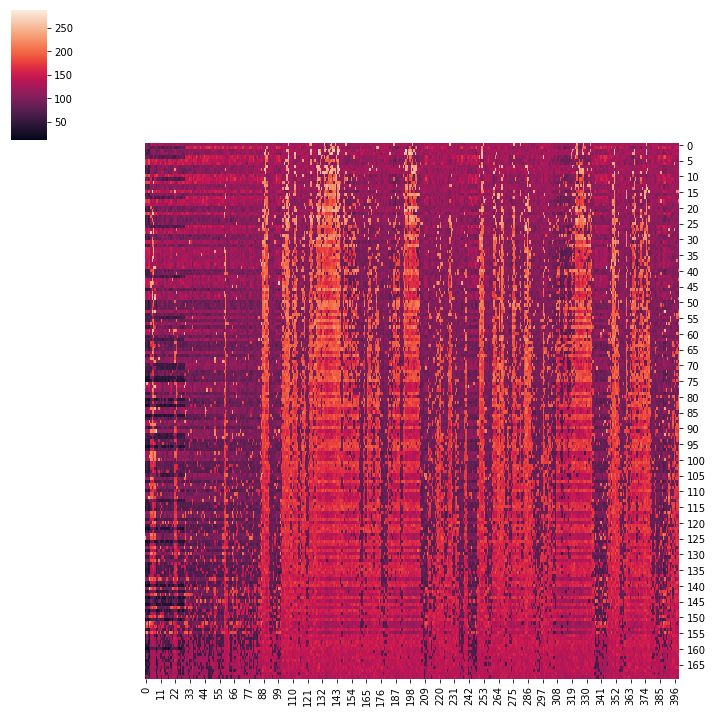

In [37]:
# normalize read depth by true CN
reads_norm_by_cn = reads_norm / torch.argmax(diploid_cn_prior, dim=2)

sns.clustermap(reads_norm_by_cn.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)
plt.show()

In [38]:
def manhattan_binarization(X, MEAN_GAP_THRESH=0.7, EARLY_S_SKEW_THRESH=0.2, LATE_S_SKEW_THRESH=-0.2):
    # center and scale the data
    X = (X - np.mean(X)) / np.std(X)
    
    # fit a 2-state GMM to the data
    gm = GaussianMixture(n_components=2, random_state=0)
    states = gm.fit_predict(X)
    
    # use GMM means to assign binary values for thresholding
    mean_0 = gm.means_[0][0]
    mean_1 = gm.means_[1][0]

    # find the distance between the two means for each state
    mean_gap = abs(mean_0 - mean_1)

    # assume means denote binary values
    binary_0 = min(mean_0, mean_1)
    binary_1 = max(mean_0, mean_1)
    
    X = X.flatten()
    
    # use skew to define the binary values if means are close together
    if mean_gap < MEAN_GAP_THRESH:
        cell_skew = skew(X)
        print('cell_skew', cell_skew)
        # positive skew indicates early S-phase
        if cell_skew > EARLY_S_SKEW_THRESH:
            binary_0 = np.percentile(X, 50)
            binary_1 = np.percentile(X, 95)
        # negative skew indicates late S-phase
        elif cell_skew < LATE_S_SKEW_THRESH:
            binary_0 = np.percentile(X, 5)
            binary_1 = np.percentile(X, 50)
        # assume mid-S when skew is neutral
        else:
            binary_0 = np.percentile(X, 25)
            binary_1 = np.percentile(X, 75)

    # now that binary values are selected, I must compute the Manhattan distance
    # between binarized data and X for 100 different thresholds
    threshs = np.linspace(binary_0, binary_1, 100)
    lowest_dist = np.inf
    best_t = None
    manhattan_dists = []
    for t in threshs:
        # set values to binary_1 when above t, to binary_0 when below t
        B = np.where(X>t, binary_1, binary_0)
        # compute Manhattan distance between two vectors
        dist = cityblock(X, B)
        manhattan_dists.append(dist)
        if dist < lowest_dist:
            lowest_dist = dist
            best_t = t

    # binarize X based on the best threshold
    cell_rt = np.where(X>best_t, 1, 0)
    # compute fraction of replicated bins (cell's time within s-phase)
    frac_rt = sum(cell_rt) / len(cell_rt)
    
    return cell_rt, frac_rt



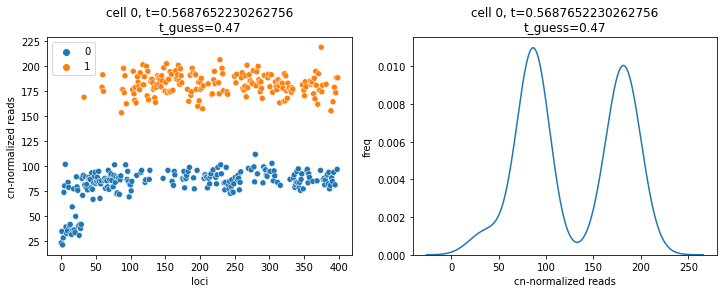

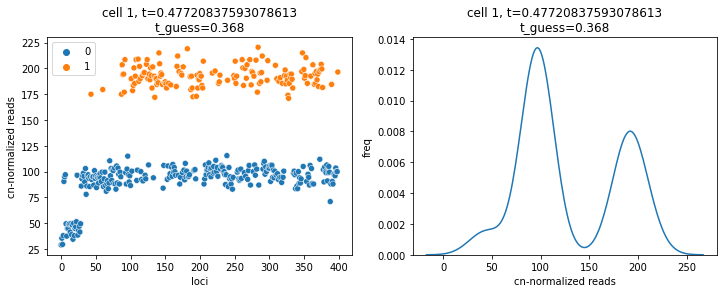

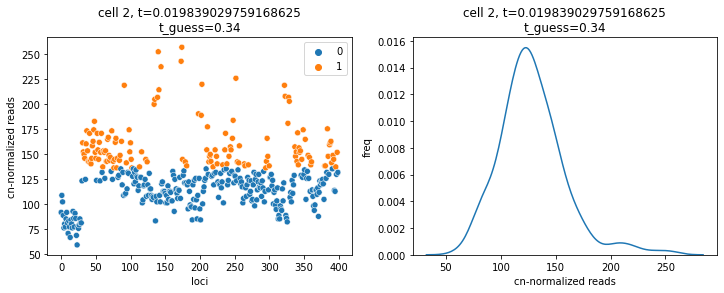

In [39]:
t_init = torch.zeros(num_cells)
t_alpha_prior = torch.zeros(num_cells)
t_beta_prior = torch.zeros(num_cells)
gamma = 6
for i in range(num_cells):
    cell_profile = reads_norm_by_cn[:, i]
    cell_t = t[i]
    cell_rep_profile = rep[:, i]
    
    X = cell_profile.numpy().reshape(-1, 1)
    y_pred2, t_guess = manhattan_binarization(X)
    
    t_init[i] = t_guess
    
    alpha = t_guess * gamma
    beta = gamma - alpha
    t_alpha_prior[i] = alpha
    t_beta_prior[i] = beta
    
    if i < 3:

        fig, ax = plt.subplots(1, 2, figsize=(12, 4))

        sns.scatterplot(x=torch.arange(0, num_loci), y=cell_profile, hue=y_pred2, ax=ax[0])
        ax[0].set_xlabel('loci')
        ax[0].set_ylabel('cn-normalized reads')
        ax[0].set_title('cell {}, t={}\nt_guess={}'.format(i, cell_t, round(t_guess, 3)))

        sns.kdeplot(x=cell_profile, ax=ax[1])
        ax[1].set_xlabel('cn-normalized reads')
        ax[1].set_ylabel('freq')
        ax[1].set_title('cell {}, t={}\nt_guess={}'.format(i, cell_t, round(t_guess, 3)))

        plt.show()



### Infer all relevant params just taking `reads_norm` as input

In [40]:

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2)


In [41]:

conditioned_model = poutine.condition(
    model_S,
    data={
# Uncomment to condition on various hidden variables
#         'a': torch.tensor([10.]),
#         'rep': rep,
#         't': t,
#         'rt': rt,
#         'nb_r': nb_r,
#         'cn': cn,
#         'u': u
        'beta_means': beta_means_fit,
        'beta_stds': beta_stds_fit
    })

guide = AutoDelta(
    poutine.block(conditioned_model,
                  expose=['a', 'u', 't', 'nb_r', 'rt', 'cn_prob', 'betas', 'beta_means', 'beta_stds'], 
                  hide=['rep', 'cn'])
)
svi = SVI(conditioned_model, guide, optim, loss=elbo)


In [42]:

# Calculate initial loss

pyro.clear_param_store()

elbo.loss(conditioned_model, guide, gc, libs, data=reads_norm, cn_prior=diploid_cn_prior, t_init=t_init)


-161462.875

In [43]:

# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi.step(gc, libs, data=reads_norm, cn_prior=diploid_cn_prior, t_init=t_init)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')
    
#     if i >= 100:
#         loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
#         if loss_diff < 0.0005:
#             print('ELBO converged at iteration ' + str(i))
#             break



...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

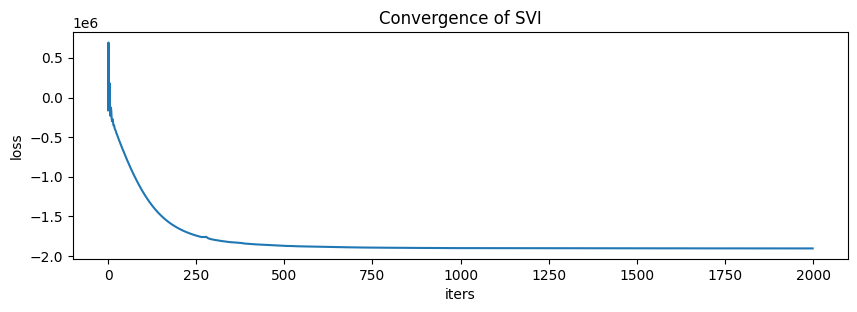

In [44]:

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');


### Visualize model output results for `rep` and `cn`

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 1., 0.]], dtype=float32)

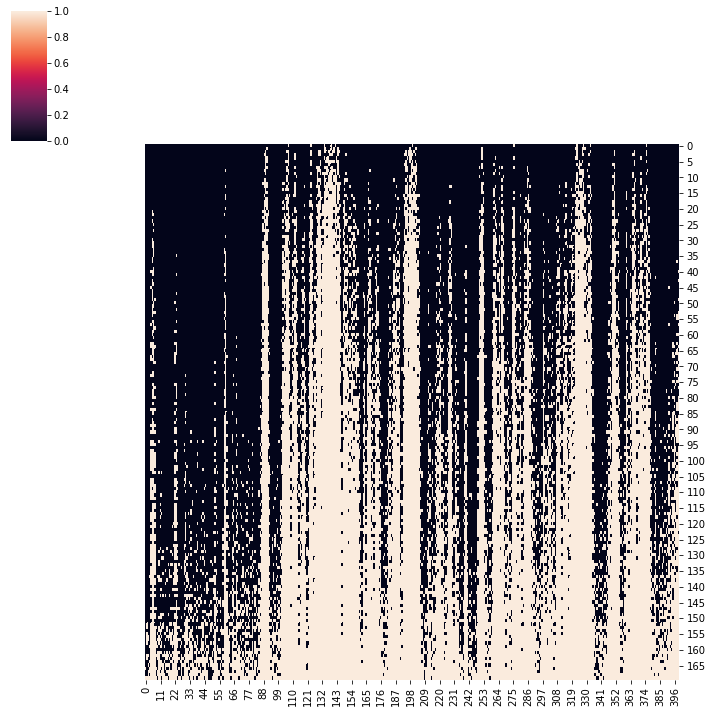

In [45]:

# Plot replicated state

guide_trace = poutine.trace(guide).get_trace(gc, libs, data=reads_norm, cn_prior=diploid_cn_prior, t_init=t_init)
trained_model = poutine.replay(conditioned_model, trace=guide_trace)

inferred_model = infer_discrete(
    trained_model, temperature=0,
    first_available_dim=-3)
trace = poutine.trace(inferred_model).get_trace(gc, libs, data=reads_norm, cn_prior=diploid_cn_prior, t_init=t_init)

sns.clustermap(trace.nodes["rep"]["value"].numpy().astype(float).T[np.argsort(t), :],
               col_cluster=False, row_cluster=False)

trace.nodes["rep"]["value"].numpy()


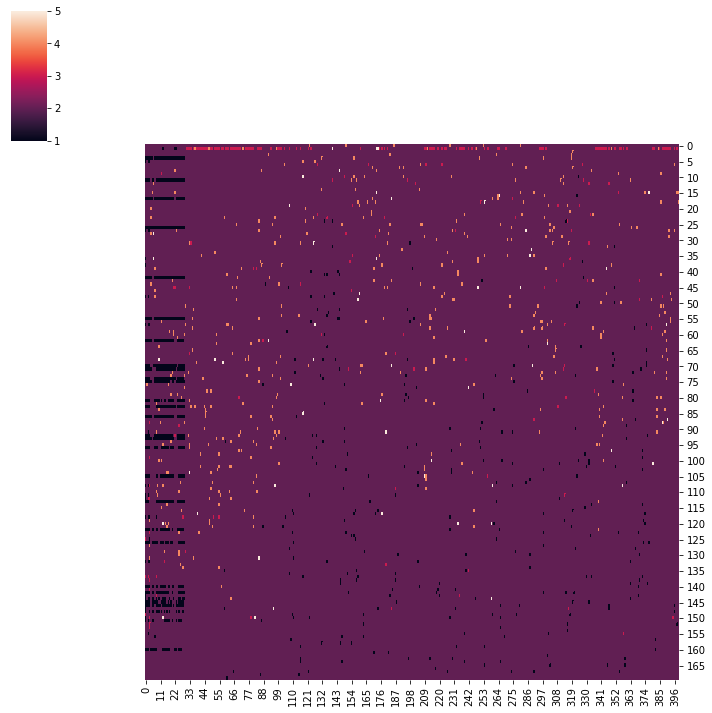

In [46]:
sns.clustermap(trace.nodes["cn"]["value"].numpy().astype(float).T[np.argsort(t), :],
               col_cluster=False, row_cluster=False)
plt.show()

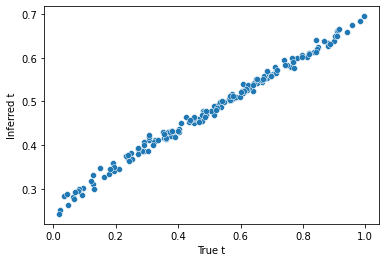

In [47]:

sns.scatterplot(
    x=t,
    y=trace.nodes["t"]["value"].detach().numpy().astype(float),
)
plt.xlabel('True t')
plt.ylabel('Inferred t')
plt.show()

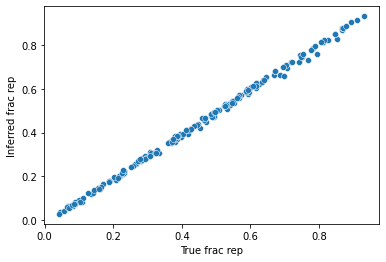

In [48]:
inferred_frac_rep = torch.mean(trace.nodes["rep"]["value"], dim=0).numpy()
true_frac_rep = torch.mean(rep, dim=0).numpy()

sns.scatterplot(
    x=true_frac_rep,
    y=inferred_frac_rep,
)
plt.xlabel('True frac rep')
plt.ylabel('Inferred frac rep')
plt.show()

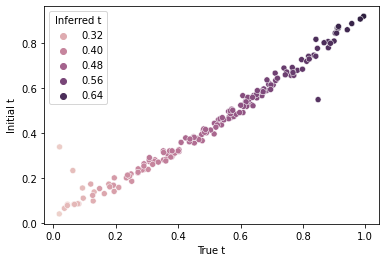

In [49]:
sns.scatterplot(
    x=t,
    hue=trace.nodes["t"]["value"].detach().numpy().astype(float),
    y=t_init
)
plt.xlabel('True t')
plt.ylabel('Initial t')
plt.legend(title='Inferred t')
plt.show()

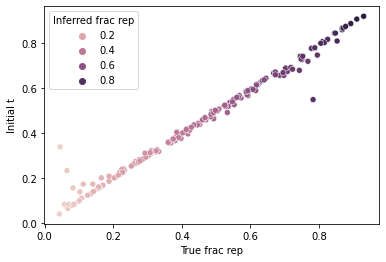

In [50]:
sns.scatterplot(
    x=true_frac_rep,
    hue=inferred_frac_rep,
    y=t_init
)
plt.xlabel('True frac rep')
plt.ylabel('Initial t')
plt.legend(title='Inferred frac rep')
plt.show()

In [51]:
# see how well S-phase model learns the betas
betas_fit_s = trace.nodes['betas']['value']
beta_means_fit_s = trace.nodes['beta_means']['value']
beta_stds_fit_s = trace.nodes['beta_stds']['value']

IndexError: index 170 is out of bounds for dimension 0 with size 170

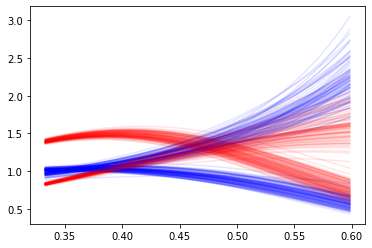

In [52]:
x = np.linspace(min(gc), max(gc), 101)  # gc values

for i in range(cn.shape[0]):
    # true gc betas
    p1d = np.poly1d(betas_s[i].detach().numpy())
    mean = np.exp(p1d(x))
    plt.plot(x, mean, 'r', alpha=0.1)

    # inferred gc betas
    p1d_fit = np.poly1d(betas_fit_s[i].detach().numpy())
    mean_fit = np.exp(p1d_fit(x))
    plt.plot(x, mean_fit, 'b', alpha=0.1)

plt.xlabel('gc')
plt.ylabel('mean norm reads')
plt.title('Learning GC bias from all cells')
#plt.legend()
plt.show()

### Evaluate how well the model classifies S-phase cells and infers replication states within them

In [ ]:
inferred_rep = trace.nodes['rep']['value']
# n = int(num_cells/3)

# inferred_rep_s = inferred_rep[:, :n]
# inferred_rep_g1 = inferred_rep[:, n:2*n]
# inferred_rep_g2 = inferred_rep[:, 2*n:]

# inferred_frac_rep_s = inferred_frac_rep[:n]
# inferred_frac_rep_g1 = inferred_frac_rep[n:2*n]
# inferred_frac_rep_g2 = inferred_frac_rep[2*n:]

In [ ]:
# plt.hist(x=inferred_frac_rep_s, label='S', color='b', alpha=0.2, range=(0,1), bins=25)
# plt.hist(x=inferred_frac_rep_g1, label='G1', color='g', alpha=0.2, range=(0,1), bins=25)
# plt.hist(x=inferred_frac_rep_g2, label='G2', color='r', alpha=0.2, range=(0,1), bins=25)
# plt.legend(title='true state')
# plt.xlabel('Inferred frac rep')
# plt.ylabel('# cells')
# plt.title('Fitting all cells to S-phase model')
# plt.show()

In [ ]:
# compute replication state accuracy for just s-phase cells
rep_accuracy = 1.0 - (np.sum(abs(rep.numpy() - inferred_rep.numpy())) / (inferred_rep.shape[0] * inferred_rep.shape[1]))
rep_accuracy

In [ ]:
# evaluate cn accuracy for the S-phase cells
inferred_cn = trace.nodes["cn"]["value"]

# inferred_cn_s = inferred_cn[:, :n]
# inferred_cn_g1 = inferred_cn[:, n:2*n]
# inferred_cn_g2 = inferred_cn[:, 2*n:]

cn_accuracy_s = 1.0 - (np.sum(abs(cn.numpy() - inferred_cn.numpy())) / (inferred_cn.shape[0] * inferred_cn.shape[1]))
cn_accuracy_s

### Try to infer using model with HMM structure for CN

In [ ]:
@config_enumerate
def model_S2(cn0=None, rt0=None, num_cells=None, num_loci=None, data=None, trans_mat=None, cn_prior=None, t_alpha_prior=None, t_beta_prior=None):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn0 is not None:
            num_loci, num_cells = cn0.shape
        assert num_cells is not None
        assert num_loci is not None

    # controls the consistency of replicating on time
    a = pyro.sample('expose_a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))
    
    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)
    
    # transition probabilities for HMM
    if trans_mat is None:
        trans_mat = pyro.sample('expose_trans_prob',
                                dist.Dirichlet(0.99 * torch.eye(13) + 0.01).to_event(1))
    
    if rt0 is not None:
        # fix rt as constant when input into model
        rt = rt0
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

    with pyro.plate('num_cells', num_cells):
        
        # per cell replication time
        # draw from prior if provided
        if (t_alpha_prior is not None) and (t_beta_prior is not None):
            t = pyro.sample('expose_t', dist.Beta(t_alpha_prior, t_beta_prior))
        else:
            t = pyro.sample('expose_t', dist.Beta(torch.tensor([1.5]), torch.tensor([1.5])))
        
        # per cell reads per copy per bin
        # u should be inversely related to t and cn, positively related to reads
        if data is not None:
            if cn0 is not None:
                cell_ploidies = torch.mean(cn0.type(torch.float32), dim=0)
            elif cn_prior is not None:
                temp_cn0 = torch.argmax(cn_prior, dim=2).type(torch.float32)
                cell_ploidies = torch.mean(temp_cn0, dim=0)
            else:
                cell_ploidies = torch.ones(num_cells) * 2.
            u_guess = torch.mean(data.type(torch.float32), dim=0) / ((1 + t) * cell_ploidies)
        else:
            u_guess = torch.tensor([70.])
        
        u_stdev = u_guess / 10.
    
        u = pyro.sample('expose_u', dist.Normal(u_guess, u_stdev))

        # starting states for markov chain
        if cn0 is None:
            cn = 2

        for l in pyro.markov(range(num_loci)):

            # sample copy number states using HMM structure
            if cn0 is None:
                temp_cn_prob = trans_mat[cn]
                if cn_prior is not None:
                    temp_cn_prob = temp_cn_prob * cn_prior[l]
                cn = pyro.sample("cn_{}".format(l), dist.Categorical(temp_cn_prob),
                                 infer={"enumerate": "parallel"})
            else:
                # no need to sample cn when true cn0 is provided to the model
                cn = cn0[l]
                
            # per cell per bin late or early 
            time_diff = t.reshape(-1, num_cells) - rt[l]

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * time_diff))

            # binary replicated indicator
            rep = pyro.sample('rep_{}'.format(l), dist.Bernoulli(p_rep))
            
            # copy number accounting for replication
            rep_cn = cn * (1. + rep)

            # expected reads per bin per cell
            expected_reads = (u * rep_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            
            if data is not None:
                obs = data[l]
            else:
                obs = None
            
            reads = pyro.sample('reads_{}'.format(l), dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)


In [ ]:
# # build the transition matrix using cn
# def build_trans_mat(cn, num_states=13):
#     num_loci, num_cells = cn.shape
#     trans_mat = torch.eye(num_states, num_states) + 10
#     for i in range(num_cells):
#         for j in range(1, num_loci):
#             cur_state = int(cn[j, i])
#             prev_state = int(cn[j-1, i])
#             trans_mat[prev_state, cur_state] += 1
#     return trans_mat

# trans_mat = build_trans_mat(torch.argmax(cn_prior, dim=2))
# diploid_trans_mat = build_trans_mat(torch.argmax(diploid_cn_prior, dim=2))

In [ ]:
# conditioned_model = poutine.condition(
#     model_S2,
#     data={
# # Uncomment to condition on various hidden variables
# #         'a': torch.tensor([10.]),
# #         'rep': rep,
# #         't': t,
# #         'rt': rt,
# #         'nb_r': nb_r,
# #         'cn': cn,
# #         'u': u
#     })

# # conditioned_model_G1 = poutine.condition(
# #     model_S,
# #     data=condition_dict
# # )

# guide = AutoDelta(
#     poutine.block(conditioned_model, expose_fn=lambda msg: msg["name"].startswith("expose_"))
# )

# svi = SVI(conditioned_model, guide, optim, loss=elbo)


In [ ]:
# elbo.loss(conditioned_model, guide, data=reads_norm, cn_prior=diploid_cn_prior, trans_mat=diploid_trans_mat, 
#           t_alpha_prior=t_alpha_prior, t_beta_prior=t_beta_prior)

In [ ]:
# Learn the model and guide params

# pyro.clear_param_store()


# losses = []
# for i in range(2000):
#     loss = svi.step(data=reads_norm, cn_prior=diploid_cn_prior, trans_mat=diploid_trans_mat, t_alpha_prior=t_alpha_prior, t_beta_prior=t_beta_prior)
#     losses.append(loss)
    
#     if i >= 100:
#         loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
#         if loss_diff < 5e-5:
#             print('ELBO converged at iteration ' + str(i))
#             break
    
#     print('.' if i % 80 else '\n', end='')


In [ ]:
# plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
# plt.plot(losses)
# plt.xlabel('iters')
# plt.ylabel('loss')
# # plt.yscale('log')
# plt.title('Convergence of SVI');

In [ ]:
# Extract fitted values

# guide_trace = poutine.trace(guide).get_trace(data=reads_norm, cn_prior=diploid_cn_prior, 
#                                              trans_mat=diploid_trans_mat, t_alpha_prior=t_alpha_prior, 
#                                              t_beta_prior=t_beta_prior)
# trained_model = poutine.replay(conditioned_model, trace=guide_trace)

# inferred_model = infer_discrete(
#     trained_model, temperature=0,
#     first_available_dim=-2)
# trace = poutine.trace(inferred_model).get_trace(data=reads_norm, cn_prior=diploid_cn_prior,
#                                                 trans_mat=diploid_trans_mat, t_alpha_prior=t_alpha_prior,
#                                                 t_beta_prior=t_beta_prior)

# model_rep = torch.zeros(cn.shape)
# model_cn = torch.zeros(cn.shape)
# model_rep_cn = torch.zeros(cn.shape)
# model_reads = torch.zeros(cn.shape)
# for l in range(cn.shape[0]):
#     temp_rep = trace.nodes['rep_{}'.format(l)]['value']
#     temp_cn = trace.nodes['cn_{}'.format(l)]['value']
#     temp_rep_cn = temp_cn * (1. + temp_rep)
#     temp_reads = trace.nodes['reads_{}'.format(l)]['value']
#     model_rep[l] = temp_rep
#     model_cn[l] = temp_cn
#     model_rep_cn[l] = temp_rep_cn
#     model_reads[l] = temp_reads

In [ ]:
# sns.clustermap(model_rep.numpy().astype(float).T[np.argsort(t), :],
#                col_cluster=False, row_cluster=False)
# plt.show()

In [ ]:
# sns.clustermap(model_cn.numpy().astype(float).T[np.argsort(t), :],
#                col_cluster=False, row_cluster=False)
# plt.show()

In [ ]:
# sns.scatterplot(
#     x=t,
#     y=trace.nodes["expose_t"]["value"].detach().numpy().astype(float),
# )
# plt.xlabel('True t')
# plt.ylabel('Inferred t')
# plt.show()